# Bounding Box Creation 

In [54]:
from PIL import Image
import numpy
import matplotlib.pyplot as plt
import math
import os,cv2
import operator
from typing import Type, NewType,List  # you have to import Type

### Load Image ###

In [55]:
def loadImage(path,name):
    image = Image.open('{path}/{name}'.format(path=path,name=name)).convert('L')
    testData = 255 - numpy.asarray(image)   
    return testData

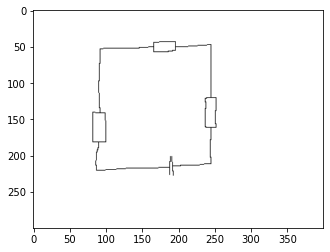

In [56]:
image = loadImage("./../src/testImages/","0.png")
plt.imshow(image, cmap=plt.cm.binary,interpolation="bilinear")

## Drawing Functions ##

In [ ]:
def createIndependetCopy(img):
    newImg = numpy.empty_like(img)
    newImg[:] = img
    return newImg


def drawCicle(image,center, radius,width=1,color=(0,0,0)):
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            dist = math.sqrt((center.x-x)**2 + (center.y-y)**2)
            if dist <= radius+width and dist >= radius-width :
                image[y][x] = color
    return image
                

def drawRect(image,center, dist,color):
    startX = math.floor(center.x-dist)
    startY = math.floor(center.y-dist)

    endX = math.floor(center.x+dist)
    endY = math.floor(center.y+dist)

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


def cropRect(img,center, dist):
    newImg = createIndependetCopy(img)
    if dist % 2 != 0:
        dist +=1
    i = []
    for y in range(0,len(newImg)):
        for x in range(0,len(newImg[y])):
           if x > center.x-dist and x <= center.x+dist and y > center.y-dist and y <= center.y+dist:
               i.append(newImg[y][x])
    return numpy.reshape(i,[dist*2,dist*2,3])

## Define Features ##

### Feature Types:
- End Point
- Intersection
- Center

In [ ]:
class Point():
    def __init__(self,x,y) -> None:
        self.x = x
        self.y = y
    def __str__(self) -> None:
        return '({x},{y})'.format(x=self.x,y=self.y)
    def __repr__(self):
        return str(self)
class Feature(Point):
    pass
class EndPoint(Feature):
    pass
class Intersection(Feature):
    pass
class Center(Feature):
    pass
#define new Typealias
point = Type[Point]

## Other Classes ##

In [ ]:
class Rect():
    def __init__(self,center: point,radius: int) -> None:
        self.center = center
        self.radius = radius
    def __str__(self) -> None:
        return 'Rect(center: {center},radius: {radius})'.format(center=self.center,radius=self.radius)
    def __repr__(self):
        return str(self)

#define new Typealias
rect = Type[Rect]

## Feature functions ###

In [ ]:
def getDistance(point1,point2):
    return math.sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2)

def getClosestPoint(point,pointList):
    # remove the point form the point List
    pointList = list(filter(lambda p: p != point,pointList))
    distances = list(map(lambda p: getDistance(point,p),pointList))
    indexOfMinimum = numpy.argmin(distances)
    return pointList[indexOfMinimum]

def getNClosestPoint(point,pointList,n):
    # remove the point form the point List
    pointList = list(filter(lambda p: p != point,pointList))
    distances = numpy.array(list(map(lambda p: getDistance(point,p),pointList)))
    indexiesOfMinima = (distances).argsort()[:n]
    elements = list(map(lambda index: pointList[index],indexiesOfMinima))
    return elements

def getNearPoints(point,pointList,dist):
    # remove the point form the point List
    pointList = list(filter(lambda p: p != point,pointList))
    # get the distances from the point to each point of the point List
    distances = map(lambda p: getDistance(point,p),pointList)
    distances = numpy.array(list(distances))

    elements = []
    # add every point, that has a distance smaller than dist to the elements array
    for i in range(0,len(distances)):
        if distances[i] <= dist:
            elements.append(pointList[i])
    return elements

def getPointsThatAreInTheRect(points: List[point],box: rect) -> List[point]:
    pointsIn = []
    for point in points:
        if point.x >= box.center.x - box.radius and point.x <= box.center.x + box.radius:
            if point.y >= box.center.y - box.radius and point.y <= box.center.y + box.radius:
                pointsIn.append(point)
    return pointsIn


### Set Features ###

(In the Future this is replaced by featureRecognicion Algorithm)
Features also need to be cleand

In [ ]:
endPointList = [EndPoint(189,201),
                EndPoint(191,201),
                EndPoint(188,226),
                EndPoint(193,227)]

intersectionList = [Intersection(245,161),
                    Intersection(245,120),
                    Intersection(196,50),
                    Intersection(166,50),
                    Intersection(92,141),
                    Intersection(90,181),
                    Intersection(188,216),
                    Intersection(192,214)]

## Print Feature Points

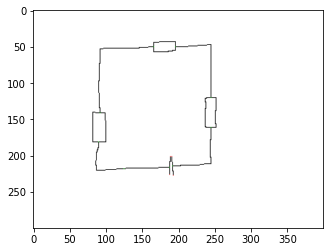

In [ ]:
#make a rgb copy form an 1 bit image
outImage = []
for y in range(0,len(image)):
    row = []
    for x in range(0,len(image[y])):
        if image[y][x] >= 1:
            row.append((0,0,0))
        else:
            row.append((255,255,255))
    outImage.append(row)

for endPoint in endPointList:
    outImage[endPoint.y][endPoint.x] = (255,0,0)

for intersection in intersectionList:
    outImage[intersection.y][intersection.x] = (0,255,0)
    
plt.imshow(outImage, interpolation='bilinear')

## Create Bounding Boxes ##

Algorithm 1: (for Resistors and Caps)
1) for every intersection get the closest other intersection 
2) create a center point between the intersection and the closest intersection
3) get the distance to the closest point
4) get all nearest endpoints which are closer than 3 * the distance to the closest intersection (measured form the center)
5) if there are any endpoints:
   1) get the distance form the intersection to the endpoint that is the largest and use this distance as radius
6) if there arent any endpoints:
   1) use the distance form the intersection to the closest intersection as radius
7) draw a rect form the center point using the radius


Improvement:
Only create a bounding box if there are 0 or 4 Endpoints inside of it

Algorithm 2: (for ground symbols)
1) for every intersection get the 2 closest endpoints
2) get the maximum distance between the intersection and the endpoints and use it as radius
3) draw a rect form the intersection using the radius


Imporvement:
If there is a intersection point inside of the rectangle, remove it!

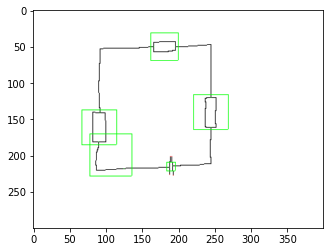

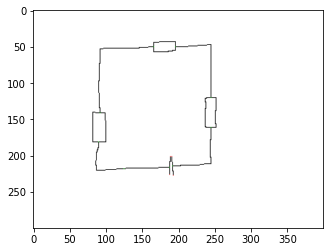

In [ ]:
def algorithm1(intersectionList,endPointList,image):
    rectList = []
    rectOffset = 4
    for intersection in intersectionList:
        closestPoint = getClosestPoint(intersection,intersectionList)
        center = Point((closestPoint.x-intersection.x)/2+intersection.x,(closestPoint.y-intersection.y)/2+intersection.y)

        distToClosePoint = math.floor(getDistance(closestPoint,center))
        nerestEndPoints = getNearPoints(center,endPointList,distToClosePoint*3)

        if(len(nerestEndPoints) != 0):
            dist = max(  list(  map(lambda x: getDistance(x,center),nerestEndPoints)))
        else:
            dist = distToClosePoint
        
        boundingBox = Rect(center,dist+rectOffset)
        #improvement
        #check if there are exactily 0 or 4 endpoins in the rect
        endpointsInBoundingBox = len(getPointsThatAreInTheRect(endPointList,boundingBox))
        if endpointsInBoundingBox == 0 or endpointsInBoundingBox == 4:
            rectList.append(boundingBox)
            image = drawRect(image=image,center=center,dist=dist+rectOffset,color=(0,255,0))
    return image,rectList

def algorithm2(intersectionList,endPointList,image):
    rectList = []
    for intersection in intersectionList:
        closestPoints = getNClosestPoint(intersection,endPointList,n=2)
        dist = max(list(map(lambda x: getDistance(x,intersection),closestPoints)))
        boundingBox = Rect(intersection,dist)
        #improvement
        #check if there are any intersection points in the bounding box
        intersectionPointsInBoundinBox = len(getPointsThatAreInTheRect(intersectionList,boundingBox))
        if intersectionPointsInBoundinBox <= 1:
            rectList.append(boundingBox)
            image = drawRect(image=image,center=intersection,dist=dist,color=(0,0,255))   
    return image,rectList

imageWithGreenRect = createIndependetCopy(outImage)
imageWithBlueRect = createIndependetCopy(outImage)

# Algorithm 1
(imageWithGreenRect,rectList1) = algorithm1(intersectionList,endPointList,imageWithGreenRect)

# Algorithm 2 
(imageWithBlueRect,rectList2) = algorithm2(intersectionList,endPointList,imageWithBlueRect)

plt.imshow(imageWithGreenRect, interpolation='bilinear') 
plt.figure()
plt.imshow(imageWithBlueRect, interpolation='bilinear') 
